In [ ]:
import pandas as pd 

#Importo el dataset desde github utilizando pandas
df = pd.read_csv('https://raw.githubusercontent.com/ignaciorlando/duia-ml-datasets/master/Insurance/insurance.csv')

#lo imprimo
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


El problema a resolver es el de encontrar el costo que tendra el seguro para cada persona segun ciertos atributos. En este caso los atributos son la edad, cantidad de hijos, sexo, si es o no fumadora, region a la que pertenece y el indice de masa corporal.

Age: valor continuo hasta rango indefinido (lo podria definir si el seguro dice hasta que edad permiten, pero este no es el caso)

Sex: hombre o mujer (posible bias). Esto podría generar un bias en los modelos si hay alguna diferencia segun el valor. Se estudiará si corresponde mantenerlo o no, ya que puede ser el caso de que los seguros se basen en gran medida en este atributo.

BMI: indice de masa corporal. Valor continuo desde y hasta rango indefinido.

Children: cantidad de hijos que tiene la persona. Variable continua que puede ir desde 0 hasta rango indefinido.

Smoker: variable categórica (binaria) que indica si la persona fuma o no.

Region: variable categórica (cantidad de regiones) que indica la región a la que pertenece la persona. Este atributo podría generar un bías, aunque (a mi forma de ver) es un atributo válido ya que, en un ejemplo conocido de la ciudad de Tandil, vivir cerca de una cantera lleva a la población de esa zona a enfermarse más ya que aspiran el polvillo del aire.

Charges: cuanto costaría el seguro de la persona.

In [ ]:
#Vemos la cantidad de filas de clientes hombres y mujeres
df['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

female         AxesSubplot(0.1,0.15;0.363636x0.75)
male      AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

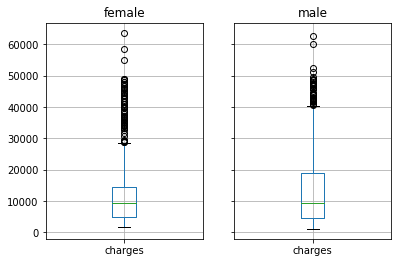

In [ ]:
#Vamos a ver el costo del seguro para ambos generos
df[['sex','charges']].groupby('sex').boxplot()

Se observa que no hay gran diferencia en el costo del seguro, por lo que podemos suponer que no generan un gran bias en los datos.

A pesar de esto, se opta por eliminar este atributo ya que, hoy en día, separar entre hombre y mujer no es algo correcto, a pesar de que se poseen cuerpos biológicamente distintos y, por lo tanto, diferentes probabilidades de enfermarnos, por lo que se eliminara esta columna.

In [ ]:
df.drop('sex', axis=1, inplace=True)
df

,age,bmi,children,smoker,region,charges
0,19,27.900,0,yes,southwest,16884.92400
1,18,33.770,1,no,southeast,1725.55230
2,28,33.000,3,no,southeast,4449.46200
3,33,22.705,0,no,northwest,21984.47061
4,32,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...
1333,50,30.970,3,no,northwest,10600.54830
1334,18,31.920,0,no,northeast,2205.98080
1335,18,36.850,0,no,southeast,1629.83350
1336,21,25.800,0,no,southwest,2007.94500


In [ ]:
#Vemos si existe alguna fila duplicada
duplicated_values = df.duplicated()
df[duplicated_values]

,age,bmi,children,smoker,region,charges
581,19,30.59,0,no,northwest,1639.5631


In [ ]:
#Al existir una fila duplicada tenemos que tener cuidado por si es otra instancia diferente o si es la misma
#instancia escrita dos veces. Al tener datos tan especificos como bmi, podemos asumir que son la misma 
#instancia, ya que dificilmente habrá dos personas con los mismos valores (y menos en tan pocos datos).
#Esto se realiza para evitar que caiga la misma fila en training y validation/test.

df.drop_duplicates(inplace=True)
df.shape

(1337, 6)

In [ ]:
#Dividimos los datos de entrenamiento del atributo de salida
x = df[['age','bmi','children','smoker','region']]
y = df['charges']

In [ ]:
#Pre proceso los atributos smoker y region para que sean valores numéricos
x.loc[x['smoker']=='yes','smoker'] = 1
x.loc[x['smoker']=='no','smoker'] = 0

dict = {} #Aca guardo los valores que tomo cada valor de region
i = 0
for reg in x[~x['region'].duplicated()]['region']:
  dict[reg] = i
  x.loc[x['region'] == reg, 'region'] = i
  i = i + 1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
x

,age,bmi,children,smoker,region
0,19,27.900,0,1,0
1,18,33.770,1,0,1
2,28,33.000,3,0,1
3,33,22.705,0,0,2
4,32,28.880,0,0,2
...,...,...,...,...,...
1333,50,30.970,3,0,2
1334,18,31.920,0,0,3
1335,18,36.850,0,0,1
1336,21,25.800,0,0,0


Realizamos la separación entre train/val/test. Utilizando para train 80% de los datos, para validación 10% de los datos de train y para test el 20% restante de todo el conjunto.

In [ ]:
from sklearn.model_selection import train_test_split

#Se realiza shuffle para asegurarnos que los datos van a estar mezclados en todas las particiones
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.1)

In [ ]:
#Cantidad de instancicas por cada particion
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(962, 5)
(107, 5)
(268, 5)


Vemos si se mantiene la distribucion de los datos en los tres conjuntos

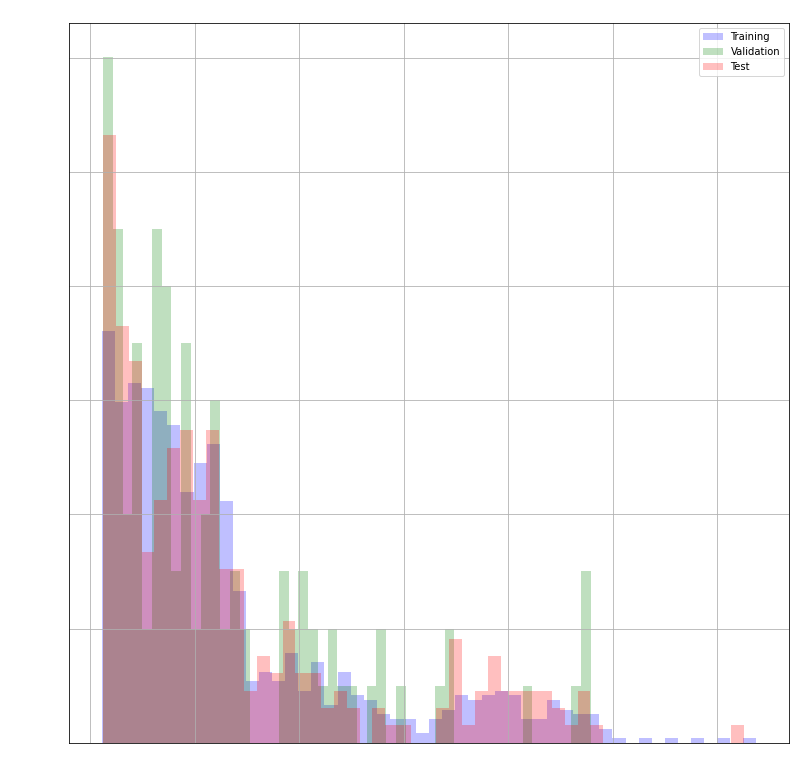

In [ ]:
from matplotlib import pyplot as plt

relative_frequency = True
n_bins = 50

# creamos el canvas de la figura
fig=plt.figure(figsize=(10,10))
# agregamos los ejes
ax=fig.add_axes([0,0,1,1])
# hacemos histogramas de 50 baldes para los datos de entrenamiento, validación y
# test, en los colores azul (b), verde (g) y rojo (r), con cierta transparencia 
# alpha
ax.hist(y_train, n_bins, density=relative_frequency, facecolor='b', alpha=0.25)
ax.hist(y_val, n_bins, density=relative_frequency, facecolor='g', alpha=0.25)
ax.hist(y_test, n_bins, density=relative_frequency, facecolor='r', alpha=0.25)
# agregamos las etiquetas de los ejes x e y
ax.set_xlabel('Charge (y-label)', color='white')
if relative_frequency:
  ax.set_ylabel('Relative Frequency', color='white')
else:
  ax.set_ylabel('Absolute Frequency', color='white')

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# le colocamos un título
ax.set_title(
    'Histograms of y - Training, validation and test set', 
    color='white'
    )
# agregamos la leyenda
ax.legend(['Training', 'Validation', 'Test'])
ax.grid(True)
# lo mostramos por pantalla
plt.show()

Se observa que la particion de los datos tiene una distribución similar, por lo que podemos trabajar con los mismos sin problema. Se aplico la frecuencia relativa para poder observar mas detalladamente si son o no similares.

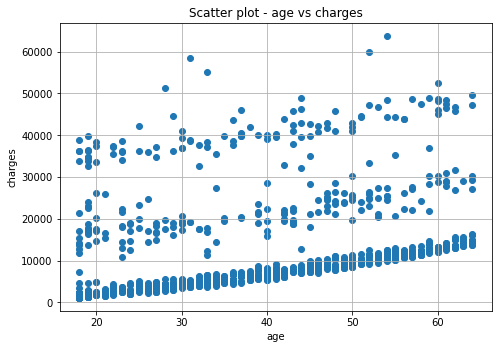

In [ ]:
from matplotlib import pyplot as plt
#'age','bmi','children','smoker','region','charges'(y)
#eje    [x  ,  y]
tag = ['age','charges']


# modificar esta variable con el índice de la feature que se quiere analizar
variable_to_print = 2

# generamos un scatter plot: por defecto, la variable objetivo la colocamos en 
# el eje Y, y a la variable cuya influencia queremos estudiar la colocamos en el 
# eje X
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
if tag[1] == 'charges':
  ax.scatter(x_train[tag[0]], y_train)
else:
  ax.scatter(x_train[tag[0]], x_train[tag[1]])

ax.grid(True)
ax.set_xlabel(tag[0])
ax.set_ylabel(tag[1])
ax.set_title('Scatter plot - {} vs {}'.format(tag[0], tag[1]))
plt.show()

Age vs Charges: se observan tres "lineas" crecientes, las cuales deben poseer tanta diferencia en el costo debido a otros atributos. Se podría decir que mientras mas alta es la edad más caro es el monto del seguro, aunque esto se ve influenciado por otros atributos tambien. Tiene sentido ya que la edad influye en gran modo al costo de un seguro (una persona mayor es mas propensa a enfermarse).

BMI vs Charges: no hay ninguna relacion directa. Con un BMI de valores 35 es donde se agrupan los valores mas altos de seguro. Yo creería que mientras más elevado es el BMI más alto debería ser el monto del seguro, pero por lo visto no es así. Necesito más información para comprender por qué sucede esto.

Children vs Charges: en caso de tener 4 hijos el monto baja y en caso de tener 5 disminuye aún más. Esto puede deberse a que la gente con muchos hijos debe mantenerse sana para poder lidiar con todo.

Smoking vs Charges: si fumas el seguro es mas caro porque hay mas chances de enfermarte...

Region vs Charges: no se visualiza ninguna diferencia notable enrte las diferentes regiones.

Region vs BMI: la gente de southeast parece ser la mas obesa. Esto puede deberse al estilo de vida que se lleva en ese lugar.


Pasamos a la parte de estandarización de los datos...


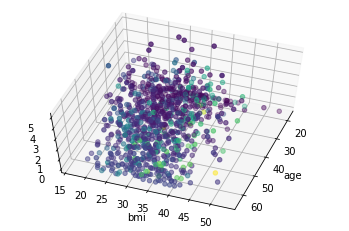

In [ ]:
#Se plotea en 3D los tres atributos continuos que se tienen
#y se observa, principalmente, que en la mayoria de los casos a menor edad es mas barato

ax = plt.axes(projection='3d')
#Tocar los siguientes valores para ver desde otra perspectiva el grafico
ax.view_init(60, 20)

ax.scatter3D(x_train['age'], x_train['bmi'], x_train['children'], c=y_train, cmap='viridis');
plt.grid(True)
plt.xlabel('age')
plt.ylabel('bmi')
#No me deja mostrar los colores, pero mas oscuro es mas barato y mas claro mas caro
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

#Aplico estandarización a TODOS los atributos continuos.
#A los discretos que los transforme en numeros NO porque no tiene sentido.
ss = StandardScaler() #Hay que guardar ss para futuros valores (val, test, datos en situacion real)
scaler.fit(x_train[['age','bmi','children']])
x_train[['age','bmi','children']] = scaler.transform(x_train[['age','bmi','children']])

In [ ]:
x_train

,age,bmi,children,smoker,region
734,1.381527,0.234895,1.567843,0,0
1122,0.952369,1.010829,1.567843,1,2
1041,-1.551048,-1.234652,-0.918308,0,3
75,1.238474,0.546246,-0.918308,0,2
1172,1.166948,1.834036,-0.918308,0,1
...,...,...,...,...,...
781,-1.551048,1.708517,-0.918308,0,1
1013,0.594738,0.267497,-0.089591,0,2
66,1.524579,1.375974,0.739126,0,0
54,0.022529,-0.320974,1.567843,0,2


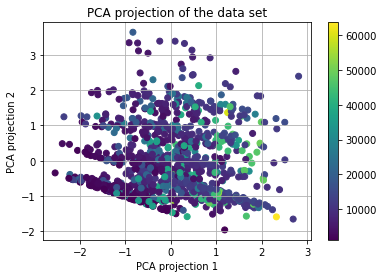

In [ ]:
# importamos la librería de PCA
from sklearn.decomposition import PCA

# declaramos un objeto PCA que mapee n dimensions a p=2 (ya que antes era p=3), y que además
# normalice esas features resultantes (whiten=True)
pca = PCA(n_components=2, whiten=True)

#Lo utilizamos unicamente para variables NO CATEGORICAS, ya que no tiene sentido...
pca = pca.fit(x_train[['age','bmi','children']])

# aplicamos la transformación aprendida sobre los datos de entrenamiento
X_train_pca = pca.transform(x_train[['age','bmi','children']])

# graficamos los datos. el color de cada punto representa el valor de la casa
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, cmap='viridis')
plt.grid(True)
plt.xlabel('PCA projection 1')
plt.ylabel('PCA projection 2')
plt.title('PCA projection of the data set')
plt.colorbar()
plt.show()

Se observa que no se encuentra una separación facilmente entendible entre los datos. Los costos mas bajos parecerian estar a la izquierda del 0 en el eje x, aunque no llega a encontrarse facilmente una separación entre los costos. Hay que tener en cuenta que no se tomaron en cuenta los atributos categóricos para este análisis, ya que sería incorrecto evaluarlas como si fuesen continuas (a pesar de ser un número, representan un valor específico, no un valor numérico).

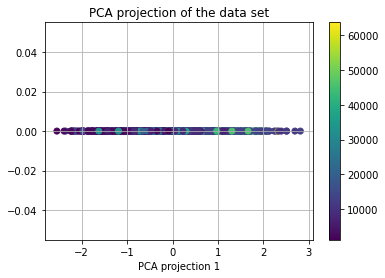

In [ ]:
# importamos la librería de PCA
from sklearn.decomposition import PCA

# declaramos un objeto PCA que mapee n dimensions a p=1, y que además
# normalice esas features resultantes (whiten=True)
pca = PCA(n_components=1, whiten=True)

#Lo utilizamos unicamente para variables NO CATEGORICAS, ya que no tiene sentido...
pca = pca.fit(x_train[['age','bmi','children']])

# aplicamos la transformación aprendida sobre los datos de entrenamiento
X_train_pca = pca.transform(x_train[['age','bmi','children']])

y_pca = X_train_pca.copy()
y_pca[:,0] = 0
# graficamos los datos. el color de cada punto representa el valor de la casa
plt.scatter(X_train_pca[:,0], y_pca, c=y_train, cmap='viridis')
plt.grid(True)
plt.xlabel('PCA projection 1')
plt.title('PCA projection of the data set')
plt.colorbar()
plt.show()

Al tener solo 3 dimensiones en los atributos originales (exceptuando los categoricos), se probó realizar un PCA para una sola dimensión y ver si se encontraba algun resultado útil. Se observa que se aclara un poco para la parte de los positivos del 0, aunque no en gran medida. 

Podemos concluir que con los datos que se poseen el gráfico que mayor nos ayudo a la visualización fue el 3D por dos motivos: 
1- nos muestra los datos en las escalas conocidas (originales)
2- se logró encontrar una especie de separación entre los datos menos costosos del resto.

PCA nos modifica las escalas y no es tan facilmente interpretable el gráfico. En este caso, al querer visualizar solo 3 valores, utilizar un gráfico 3D me parece la mejor opción.